In [46]:
import pandas as pd
import seaborn as sns
import matplotlib
%matplotlib inline

In [6]:
df = pd.read_csv('videogames.csv')  # Read raw data
df.head()                           # First 5 rows in data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()  # Raw info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [45]:
df = df.dropna(axis=0, how='any')  # Eliminate rows if they contain any NaN value
df.info()                          # Info without NaN values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
Name               6825 non-null object
Platform           6825 non-null object
Year_of_Release    6825 non-null float64
Genre              6825 non-null object
Publisher          6825 non-null object
NA_Sales           6825 non-null float64
EU_Sales           6825 non-null float64
JP_Sales           6825 non-null float64
Other_Sales        6825 non-null float64
Global_Sales       6825 non-null float64
Critic_Score       6825 non-null float64
Critic_Count       6825 non-null float64
User_Score         6825 non-null object
User_Count         6825 non-null float64
Developer          6825 non-null object
Rating             6825 non-null object
dtypes: float64(9), object(7)
memory usage: 906.4+ KB


In [53]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,174.722344
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,587.428538
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,89.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,10665.000000


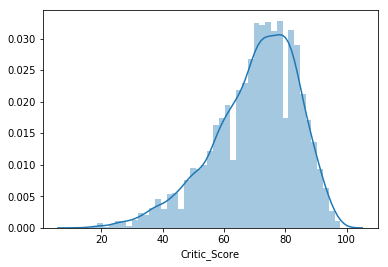

In [52]:
sns.distplot(df['Critic_Score'])